In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading

In [219]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (4999, 407)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bend_edge_angle_min_14,bend_edge_angle_max_14,bend_edge_length_mean_14,bend_edge_length_std_14,bend_edge_length_min_14,bend_edge_length_max_14,VAMAT,VALAJOUT,VALTOT,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.51,5.15,17.66,>4
L1600700,625.429871,2,0,10823.929688,12759.00000,255.179993,50.000000,11152.315430,11152.315430,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.61,2.36,1-2
L1600710,625.429871,2,0,10823.929688,12759.00000,255.179993,50.000000,11152.315430,11152.315430,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.61,2.36,1-2
L1604370,1331.470215,2,0,50167.941406,86430.78125,402.004486,214.999557,60628.445312,60628.445312,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.51,2.61,16.12,0
L1605520,2439.510254,10,0,57224.437500,108800.00000,680.000000,160.000000,93438.500000,60505.269531,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.01,4.07,11.08,0


In [220]:
dataset.columns.values

array(['cut_length', 'num_closed_patterns', 'num_open_patterns',
       'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1',
       'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',
       'thickness', 'radius_count', 'direction_count', 'bend_count',
       'bend_radius_00', 'bend_angle_00', 'bend_direction_00',
       'deformation_length_00', 'merged_bend_00', 'punch_length_00',
       'bend_radius_01', 'bend_angle_01', 'bend_direction_01',
       'deformation_length_01', 'merged_bend_01', 'punch_length_01',
       'bend_radius_02', 'bend_angle_02', 'bend_direction_02',
       'deformation_length_02', 'merged_bend_02', 'punch_length_02',
       'bend_radius_03', 'bend_angle_03', 'bend_direction_03',
       'deformation_length_03', 'merged_bend_03', 'punch_length_03',
       'bend_radius_04', 'bend_angle_04', 'bend_direction_04',
       'deformation_length_04', 'merged_bend_04', 'punch_length_04',
       'bend_radius_05', 'bend_angle_05', 'bend_direction_05',
 

In [221]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

deformation_length_00 --> 158
deformation_length_01 --> 71
deformation_length_02 --> 6
deformation_length_03 --> 3
deformation_length_04 --> 1
Done !


In [222]:
#Cleaning of the remaining Nan
#dataset = dataset.fillna(0)
dataset = dataset.dropna()
dataset.shape

(4820, 407)

# cleaning to have at least min occurences

In [223]:
minocc = 10
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

1.0 will be dropped
16.0 will be dropped


# Dataset re-ordering and Splitting

In [224]:
start = dataset.columns.values
todrop = ['bend_group', 'VAMAT', 'VALAJOUT', 'VALTOT']
tokeep = [x for x in start if x not in todrop ]
tokeep

['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bend_radius_00',
 'bend_angle_00',
 'bend_direction_00',
 'deformation_length_00',
 'merged_bend_00',
 'punch_length_00',
 'bend_radius_01',
 'bend_angle_01',
 'bend_direction_01',
 'deformation_length_01',
 'merged_bend_01',
 'punch_length_01',
 'bend_radius_02',
 'bend_angle_02',
 'bend_direction_02',
 'deformation_length_02',
 'merged_bend_02',
 'punch_length_02',
 'bend_radius_03',
 'bend_angle_03',
 'bend_direction_03',
 'deformation_length_03',
 'merged_bend_03',
 'punch_length_03',
 'bend_radius_04',
 'bend_angle_04',
 'bend_direction_04',
 'deformation_length_04',
 'merged_bend_04',
 'punch_length_04',
 'bend_radius_05',
 'bend_angle_05',
 'bend_direction_05',
 'deformation_length_05',
 'merged_bend_05',
 'punch_length_

In [225]:
#Dataset definition
X = dataset[tokeep]
y = dataset['VALTOT']

In [226]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0 ,stratify=dataset['bend_group'])

# Blocs creation

In [227]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [228]:
# Metric
from sklearn.metrics import mean_squared_error

In [258]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(application='regression',
                        learning_rate=0.05,
                        n_estimators=200,
                        min_child_samples=10,
                        random_state=0,
                       eval_metric='mean_squared_error',)

In [259]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [260]:
pipe = [('scaler', scaler), ('gbm', gbm)]
regpip = Pipeline(pipe)

In [261]:
regpip.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(application='regression', boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0,
       eval_metric='mean_squared_error', learning_rate=0.05, max_depth=-1,
       min_child_samples=10, m....0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1))])

In [309]:
param_grid = {
    #'gbm__learning_rate': [0.05, 0.1, ],
    #'gbm__n_estimators': [300, 400, 500],
    'gbm__min_child_samples' : [15,10,5],
    'gbm__lambda_l1': np.logspace(-3,3,4),
    'gbm__lambda_l2': np.logspace(-3,3,4),
    'gbm__max_bin':[200, 150],
    'gbm__num_leaves':[20,25],
    'gbm__max_depth':[500,750],
    #'gbm__min_split_gain':[0,.1]
    
    
}

gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=0)

In [310]:
gridgbm.fit(X_train, y_train)

KeyboardInterrupt: 

In [281]:
gridgbm.best_params_

{'gbm__lambda_l2': 0.1,
 'gbm__max_bin': 200,
 'gbm__max_depth': 500,
 'gbm__min_child_samples': 15,
 'gbm__num_leaves': 20}

In [282]:
gridgbm.best_score_

-54.03456843582746

In [283]:
mean_squared_error(y_test, gridgbm.predict(X_test))

57.0015488886866

In [284]:
mean_squared_error(y_train, gridgbm.predict(X_train))

7.8312686130382305

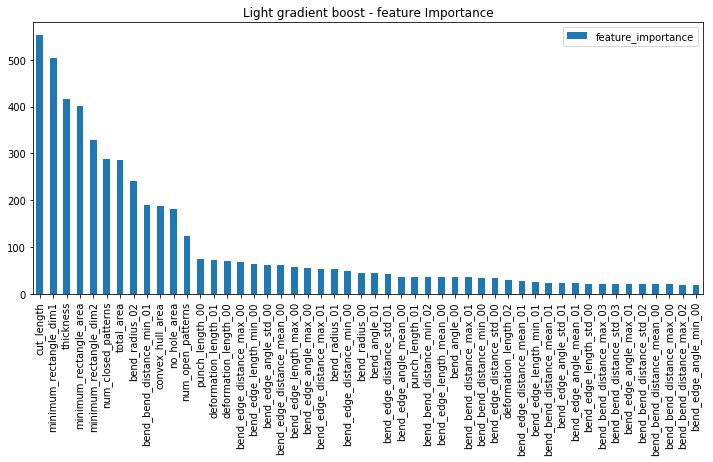

In [285]:
featimp = list(gridgbm.best_estimator_.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =X_test.columns.values)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(12,5))
plt.title('Light gradient boost - feature Importance')
plt.show()

In [123]:
gridgbm.best_estimator_.named_steps['gbm']

LGBMRegressor(application='regression', boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0,
       eval_metric='mean_squared_error', learning_rate=0.2, max_depth=-1,
       min_child_samples=2, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

# Solution comparison

In [286]:
prediction_lgbm = gridgbm.predict(X_test)

In [287]:
resultset = pd.DataFrame({'True': y_test,
                          'pred_lgbm':prediction_lgbm,
                            }, index=y_test.index)
resultset.head()

,True,pred_lgbm
COART,,
L7002771,10.48,3.184635
L8837060,2.06,1.686971
L8830800,12.57,11.815007
L3132300,5.11,5.089261
L1608750,0.95,0.852585


In [288]:
mean_squared_error(resultset['True'], resultset['pred_lgbm'])

57.0015488886866

In [289]:
resultset['RMSE_lgbm'] = (resultset['True']-resultset['pred_lgbm'])**2
resultset.head()

,True,pred_lgbm,RMSE_lgbm
COART,,,
L7002771,10.48,3.184635,53.222356
L8837060,2.06,1.686971,0.139151
L8830800,12.57,11.815007,0.570014
L3132300,5.11,5.089261,0.000430
L1608750,0.95,0.852585,0.009490


In [290]:
#
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,True,pred_lgbm,RMSE_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,...,bend_edge_distance_min_14,bend_edge_distance_max_14,bend_edge_angle_mean_14,bend_edge_angle_std_14,bend_edge_angle_min_14,bend_edge_angle_max_14,bend_edge_length_mean_14,bend_edge_length_std_14,bend_edge_length_min_14,bend_edge_length_max_14
0,L7002771,10.48,3.184635,53.222356,43.965195,2,0,65.867287,99.751518,9.987568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,L8837060,2.06,1.686971,0.139151,669.824097,3,0,11415.565430,14461.824219,156.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,L8830800,12.57,11.815007,0.570014,2340.658203,3,0,64695.941406,187936.140625,567.385620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,L3132300,5.11,5.089261,0.000430,1990.271240,4,0,78396.484375,122214.335938,561.812012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,L1608750,0.95,0.852585,0.009490,448.410370,3,0,5981.325684,7000.000000,175.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


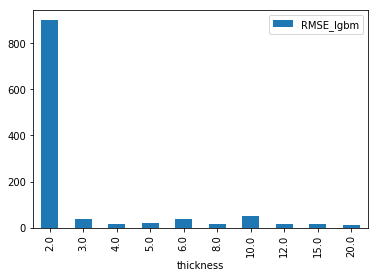

,RMSE_lgbm
thickness,
2.0,899.562766
3.0,37.804737
4.0,16.542549
5.0,19.681387
6.0,35.798961
8.0,14.031225
10.0,49.597792
12.0,15.560386
15.0,16.650662


In [291]:
# Is the error sourced by thickness ?
df = comparisonset[['RMSE_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.show()
df

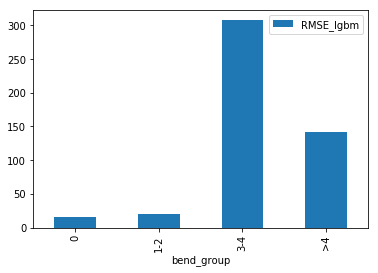

,RMSE_lgbm
bend_group,
0,14.974756
1-2,19.604318
3-4,307.231962
>4,141.146991


In [292]:
# Is the error sourced by number of errors ?
def bendgroupcalc(entry):
    if entry == 0:
        return '0'
    elif entry <= 2:
        return '1-2'
    elif entry <= 4:
        return '3-4'
    else:
        return '>4'
    return 'None'

comparisonset['bend_group'] = comparisonset['bend_count'].apply(bendgroupcalc)

df = comparisonset[['RMSE_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.show()
df

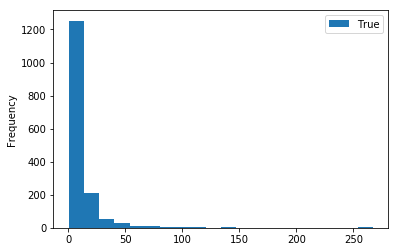

,True
count,1588.000000
mean,10.588892
std,17.264827
min,0.360000
25%,2.797500
50%,5.430000
75%,11.460000
max,267.290000


In [293]:
comparisonset[['True']].plot.hist(bins=20)
plt.show()
comparisonset[['True']].describe()

In [297]:
comparisonset['percent_error'] = (comparisonset['True'] / comparisonset['pred_lgbm'])-1
comparisonset[['True', 'pred_lgbm', 'percent_error']].head()

,True,pred_lgbm,percent_error
0,10.48,3.184635,2.290801
1,2.06,1.686971,0.221124
2,12.57,11.815007,0.063901
3,5.11,5.089261,0.004075
4,0.95,0.852585,0.114259


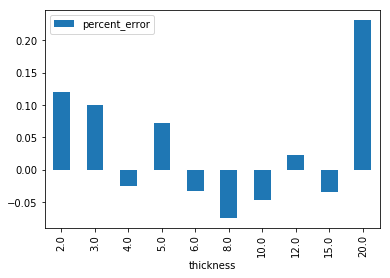

,percent_error
thickness,
2.0,0.120320
3.0,0.100170
4.0,-0.025117
5.0,0.072473
6.0,-0.032215
8.0,-0.073933
10.0,-0.046182
12.0,0.022640
15.0,-0.033620


In [298]:
df = comparisonset[['percent_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.show()
df

In [312]:
comparisonset.head()

,COART,True,pred_lgbm,RMSE_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,...,bend_edge_angle_mean_14,bend_edge_angle_std_14,bend_edge_angle_min_14,bend_edge_angle_max_14,bend_edge_length_mean_14,bend_edge_length_std_14,bend_edge_length_min_14,bend_edge_length_max_14,bend_group,percent_error
0,L7002771,10.48,3.184635,53.222356,43.965195,2,0,65.867287,99.751518,9.987568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.290801
1,L8837060,2.06,1.686971,0.139151,669.824097,3,0,11415.565430,14461.824219,156.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1-2,0.221124
2,L8830800,12.57,11.815007,0.570014,2340.658203,3,0,64695.941406,187936.140625,567.385620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.063901
3,L3132300,5.11,5.089261,0.000430,1990.271240,4,0,78396.484375,122214.335938,561.812012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3-4,0.004075
4,L1608750,0.95,0.852585,0.009490,448.410370,3,0,5981.325684,7000.000000,175.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.114259


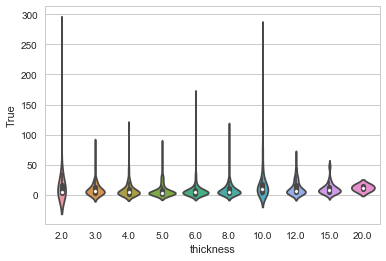

In [329]:
sns.violinplot(x="thickness", y='True', data=comparisonset, split=True)
plt.show()